# Peaks Heatmap + GridMap

Creates a peak count heatmap per cluster.

Inputs:
1. `metadata.tsv` with UMAP/densMAP coordinates, day and cluster.
2. Config:
    - Colours for each day
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)
3. Single-cell counts matrix derived from snapATAC with corresponding peaks.
4. Set of bed files corresponding to peak sets which are a subset of peaks in the above matrix.

In [82]:
library(Matrix)
library(ggplot2)
library(patchwork)
library(GenomicRanges)
library(scales)
library(DESeq2)
library(reshape2)
library(viridis)
library(ComplexHeatmap)
library(ggrastr)

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

### MetaData

In [3]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 68916     5

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
                    cells              
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA

In [4]:
# this is a kludge for now, clusters should also be present in same metaData as above
snapATAC_metaData = read.table("../../analysis/20200122_snapATAC/snapATAC_sessions/20200518_n76052/metadata.tsv", header = T)
rownames(snapATAC_metaData) = paste(snapATAC_metaData$sample, snapATAC_metaData$barcode, sep='_')

metaData$cluster = snapATAC_metaData[rownames(metaData), "cluster"] 
head(metaData)

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
D0_AAACACGCTCGAGTGA AAACACGCTCGAGTGA D0     3.408866 -9.058377
                    cells               cluster
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC 5      
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT 5      
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC 5      
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG 6      
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA 5      
D0_AAACACGCTCGAGTGA D0_AAACACGCTCGAGTGA 6

### Day and Cluster Configs

In [5]:
day_config = read.table("../configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

day colour 
D0  D0  #A61C24
D2  D2  #FF70A6
D4  D4  #D6E82F
D6  D6  #B14AED
D8  D8  #2D3142
D10 D10 #FC7753
D12 D12 #0AABB7
D14 D14 #336699

In [6]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

rownames(cluster_config) = cluster_config$cluster
cluster_config

cluster colour  description            new_cluster
1   1      #F4D5CD Intermediate           12         
2   2      #78A824 Pre-iPSC               15         
3   3      #F01D35 Fibroblast-like         5         
4   4      #E85F6D Fibroblast-like         3         
5   5      #B03743 Fibroblast              1         
6   6      #7C2730 Fibroblast              2         
7   7      #CF175A Fibroblast-like         4         
8   8      #CCCCCC Doublets               17         
9   9      #F7A6C2 Keratinocyte-like       6         
10 10      #A6D854 Pre-iPSC               16         
11 11      #406614 Partially-reprogrammed 14         
12 12      #BD6A37 Intermediate           11         
13 13      #D4B81C Intermediate           10         
14 14      #F0520A Early intermediate      7         
15 15      #F0A118 Intermediate           13         
16 16      #2BB5A3 Neural-like             9         
17 17      #006658 Neural-like             8         
18 18      #9BE89E iPSC                   18

### Insertions Count Matrix + Regions

In [7]:
pmat = readMM("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.overlap.smallpeaks.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 803958

In [8]:
peak_regions = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")
names(peak_regions) = c("chr", "bp1", "bp2")
peak_regions$site_name <- paste(peak_regions$chr, peak_regions$bp1, peak_regions$bp2, sep="_")
row.names(peak_regions) <- peak_regions$site_name
dim(peak_regions)
head(peak_regions)

[1] 803958      4

chr  bp1       bp2       site_name               
chr1_97145604_97145864   chr1  97145604  97145864 chr1_97145604_97145864  
chr1_7538148_7538363     chr1   7538148   7538363 chr1_7538148_7538363    
chr1_93196678_93196894   chr1  93196678  93196894 chr1_93196678_93196894  
chr1_187577713_187577913 chr1 187577713 187577913 chr1_187577713_187577913
chr1_53278065_53278265   chr1  53278065  53278265 chr1_53278065_53278265  
chr1_177176832_177177032 chr1 177176832 177177032 chr1_177176832_177177032

In [9]:
peak_regions_gr =  GRanges(sub("_", "-", sub("_", ":", rownames(peak_regions))))

In [10]:
# check if reads at OCT promoter (none in initial version)
sum(pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), peak_regions_gr))])

[1] 537

In [11]:
pmatRowSums = Matrix::rowSums(pmat)

### Cluster Aggregated Matrix

In [12]:
# CAREFUL: reassigning clusters to their new cluster labels! 
# ensure cluster_config is in order
new_cluster_per_cell = cluster_config$new_cluster[metaData$cluster]

agg_matrix = sparseMatrix(i=new_cluster_per_cell,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(new_cluster_per_cell)), nrow(pmat)))

In [13]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) = sub("_", "-", sub("_", ":", rownames(peak_regions)))
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5
chr1:97145604-97145864   103       145        74       141       34       
chr1:7538148-7538363     193       233       151       314       19       
chr1:93196678-93196894    82        67        12        23        2       
chr1:187577713-187577913  47        31        27         7        0       
chr1:53278065-53278265    51        26        40        58        3       
chr1:177176832-177177032  10         4         3        11        3       
                         cluster_6 cluster_7 cluster_8 cluster_9 cluster_10
chr1:97145604-97145864   43        24        30         14       73        
chr1:7538148-7538363     78        29        34         14       96        
chr1:93196678-93196894    5         1        18          1       12        
chr1:187577713-187577913  1         1         5         11       29        
chr1:53278065-53278265   24        16        12         12       37        
chr1:177176832-177177032  0        12        59        118       45        
                         cluster_11 cluster_12 cluster_13 cluster_14 cluster_15
chr1:97145604-97145864   79         74         20         33          8        
chr1:7538148-7538363     55         62         73         12         39        
chr1:93196678-93196894    1         10          4          0          3        
chr1:187577713-187577913 10         22         14          0          4        
chr1:53278065-53278265   25         47         35          5         11        
chr1:177176832-177177032  6         73         21          0          4        
                         cluster_16 cluster_17 cluster_18
chr1:97145604-97145864   8          38         0         
chr1:7538148-7538363     8          40         0         
chr1:93196678-93196894   1           6         0         
chr1:187577713-187577913 0           6         0         
chr1:53278065-53278265   5          12         0         
chr1:177176832-177177032 2           5         0

[1] 803958     18

In [14]:
# removing cluster_18 (iPSC) for now since it has very few cells
cts = cts[,1:17]

In [15]:
sum(rowSums(cts<10)==0)

[1] 157610

In [16]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts[rowSums(cts<10)==0, ]))

In [17]:
# bin length normalized
binnorm_log_cts = log2(1+200*(norm_cts/width(GRanges(rownames(norm_cts)))))

In [18]:
head(binnorm_log_cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5
chr1:97145604-97145864   5.246563  6.103949  5.142254  5.762659  6.605542 
chr1:7538148-7538363     6.404163  7.051036  6.419734  7.173951  6.046133 
chr1:93196678-93196894   5.185653  5.273154  2.943568  3.517980  2.966969 
chr1:187577713-187577913 4.517405  4.308664  4.109216  2.149078  0.000000 
chr1:53278065-53278265   4.630292  4.068840  4.648829  4.880935  3.590072 
chr1:177176832-177177032 2.500805  1.777365  1.488759  2.677745  3.590072 
                         cluster_6 cluster_7 cluster_8 cluster_9 cluster_10
chr1:97145604-97145864   5.175388  4.979347  4.772335  4.099198  5.031476  
chr1:7538148-7538363     6.285670  5.510901  5.211614  4.357630  5.683187  
chr1:93196678-93196894   2.564153  1.339581  4.321943  1.254907  2.861700  
chr1:187577713-187577913 1.043379  1.407424  2.743722  4.126457  4.117305  
chr1:53278065-53278265   4.726024  4.778318  3.875300  4.245088  4.450691  
chr1:177176832-177177032 0.000000  4.380699  6.092460  7.472753  4.721314  
                         cluster_11 cluster_12 cluster_13 cluster_14 cluster_15
chr1:97145604-97145864   6.0159274  4.647093   3.466929   5.804131   2.796274  
chr1:7538148-7538363     5.7707261  4.664150   5.503252   4.650290   5.171057  
chr1:93196678-93196894   0.9781839  2.295719   1.773708   0.000000   1.880515  
chr1:187577713-187577913 3.5200407  3.362709   3.342221   0.000000   2.281179  
chr1:53278065-53278265   4.7644690  4.381268   4.576167   3.560263   3.538173  
chr1:177176832-177177032 2.8645684  4.991634   3.878968   0.000000   2.281179  
                         cluster_16 cluster_17
chr1:97145604-97145864   3.973818   5.061117  
chr1:7538148-7538363     4.230918   5.398868  
chr1:93196678-93196894   1.683437   2.837983  
chr1:187577713-187577913 0.000000   2.933528  
chr1:53278065-53278265   3.693763   3.835877  
chr1:177176832-177177032 2.530069   2.707776

### Peak Sets

In [19]:
BASE_PATH = "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/"
list.files(BASE_PATH)

[1] "all_peaks.bed" "idx1.bed"      "idx10.bed"     "idx11.bed"    
 [5] "idx12.bed"     "idx13.bed"     "idx14.bed"     "idx15.bed"    
 [9] "idx16.bed"     "idx17.bed"     "idx18.bed"     "idx19.bed"    
[13] "idx2.bed"      "idx20.bed"     "idx21.bed"     "idx22.bed"    
[17] "idx23.bed"     "idx24.bed"     "idx25.bed"     "idx26.bed"    
[21] "idx27.bed"     "idx28.bed"     "idx29.bed"     "idx3.bed"     
[25] "idx30.bed"     "idx31.bed"     "idx32.bed"     "idx33.bed"    
[29] "idx34.bed"     "idx35.bed"     "idx36.bed"     "idx37.bed"    
[33] "idx38.bed"     "idx39.bed"     "idx4.bed"      "idx40.bed"    
[37] "idx5.bed"      "idx6.bed"      "idx7.bed"      "idx8.bed"     
[41] "idx9.bed"      "README.md"     "width_200bp"

In [20]:
PEAK_SET_BEDS = list.files(BASE_PATH, 
                           full.names=T,
                          pattern="*idx[0-9]+.bed")
PEAK_SET_NAMES = sub(".bed", "", list.files(BASE_PATH, 
                          pattern="*idx[0-9]+.bed"))
length(PEAK_SET_BEDS)
length(PEAK_SET_NAMES)

[1] 40

[1] 40

In [21]:
PEAK_SET_BEDS
PEAK_SET_NAMES

[1] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx1.bed" 
 [2] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx10.bed"
 [3] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx11.bed"
 [4] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx12.bed"
 [5] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx13.bed"
 [6] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx14.bed"
 [7] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx15.bed"
 [8] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx16.bed"
 [9] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx17.bed"
[10] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx18.bed"
[11] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx19.bed"
[12] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx2.bed" 
[13] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx20.bed"
[14] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx21.bed"
[15] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx22.bed"
[16] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx23.bed"
[17] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx24.bed"
[18] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx25.bed"
[19] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx26.bed"
[20] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx27.bed"
[21] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx28.bed"
[22] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx29.bed"
[23] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx3.bed" 
[24] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx30.bed"
[25] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx31.bed"
[26] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx32.bed"
[27] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx33.bed"
[28] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx34.bed"
[29] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx35.bed"
[30] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx36.bed"
[31] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx37.bed"
[32] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx38.bed"
[33] "../../analysis/20200307_fin

[1] "idx1"  "idx10" "idx11" "idx12" "idx13" "idx14" "idx15" "idx16" "idx17"
[10] "idx18" "idx19" "idx2"  "idx20" "idx21" "idx22" "idx23" "idx24" "idx25"
[19] "idx26" "idx27" "idx28" "idx29" "idx3"  "idx30" "idx31" "idx32" "idx33"
[28] "idx34" "idx35" "idx36" "idx37" "idx38" "idx39" "idx4"  "idx40" "idx5" 
[37] "idx6"  "idx7"  "idx8"  "idx9"

---
Assign peak set indices to peaks and remove peaks that aren't in any peak set.

In [22]:
peak_to_row_idx = rep(-1, nrow(binnorm_log_cts))

# assign peak set indices to peaks
for (i in seq(length(PEAK_SET_NAMES))) {
    cur_peaks = read.table(PEAK_SET_BEDS[[i]])
    peak_to_row_idx[rownames(binnorm_log_cts) %in% paste(paste(cur_peaks$V1, cur_peaks$V2, sep=':'), cur_peaks$V3, sep='-')] = PEAK_SET_NAMES[[i]]
}

In [23]:
sum(peak_to_row_idx== -1)

[1] 40791

In [24]:
binnorm_log_cts = binnorm_log_cts[peak_to_row_idx != -1, ]
dim(binnorm_log_cts)

[1] 763167     17

In [25]:
peak_to_row_idx = peak_to_row_idx[peak_to_row_idx != -1]

In [26]:
head(peak_to_row_idx)

[1] "idx6"  "idx9"  "idx2"  "idx2"  "idx12" "idx15"

## Plotting

In [27]:
## use this to filter by peak sets if required
PEAK_SETS_TO_EXCLUDE = c()
include_peak_set = !(peak_to_row_idx %in% PEAK_SETS_TO_EXCLUDE)

matrix_to_plot = binnorm_log_cts[include_peak_set, 1:16]
assigned_peak_idx = peak_to_row_idx[include_peak_set]

In [28]:
dim(matrix_to_plot)
length(assigned_peak_idx)

[1] 763167     16

[1] 763167

In [29]:
# compute median for each peak set to figure out order
median_matrix = aggregate(matrix_to_plot, list(assigned_peak_idx), median)
rownames(median_matrix) = median_matrix$Group.1
median_matrix$Group.1 = NULL
dim(median_matrix)
head(median_matrix)

[1] 40 16

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6 cluster_7
idx1  4.106792  4.080139  4.149764  4.259932  3.590072  4.055509  4.380699 
idx10 5.699175  5.828247  6.047475  6.439919  5.975931  6.428662  6.817125 
idx11 2.643146  2.549913  3.142096  3.368038  3.063799  5.368764  3.651730 
idx12 3.736010  3.769808  4.224160  4.623255  4.167445  5.543035  4.752291 
idx13 3.921628  3.851193  4.783794  4.729032  5.374672  4.143679  3.664273 
idx14 3.079979  2.940540  4.341207  4.019177  5.240642  3.246164  2.574802 
      cluster_8 cluster_9 cluster_10 cluster_11 cluster_12 cluster_13
idx1  5.315545  4.781818  4.244015   3.869235   3.971314   3.671965  
idx10 6.801137  6.936719  6.668476   6.747316   6.895767   6.427965  
idx11 4.427115  3.520825  3.652631   3.229215   3.561922   3.597004  
idx12 4.989548  4.640979  4.690135   4.509345   4.764029   4.653064  
idx13 4.083579  3.855191  4.455209   4.523005   4.197428   4.234955  
idx14 3.159897  2.750808  3.572880   3.096108   2.874176   3.143344  
      cluster_14 cluster_15 cluster_16
idx1  2.902610   2.615375   2.361156  
idx10 6.018483   5.361427   4.558482  
idx11 2.902610   3.124576   3.287899  
idx12 3.900736   3.911545   3.762995  
idx13 4.750131   3.826259   3.475904  
idx14 3.268590   2.745444   2.530069

In [30]:
# default order
peak_set_order = rownames(median_matrix)[order(nchar(rownames(median_matrix)), rownames(median_matrix))]

# order peak sets -- using a heurestic here to get diagonal structure
# peak_set_order = rownames(median_matrix)[order(rowSums(t(seq(1,ncol(median_matrix))*t(2**(median_matrix)-1)))/rowSums(2**(median_matrix)-1))]
# peak_set_order = rownames(median_matrix)[order(rowSums(t(seq(1,ncol(median_matrix))*t(median_matrix)))/rowSums(median_matrix))]
# peak_set_order = rownames(median_matrix)[order(rowSums(t(seq(1,ncol(median_matrix))*(scale(t(median_matrix))))))]
peak_set_order

[1] "idx1"  "idx2"  "idx3"  "idx4"  "idx5"  "idx6"  "idx7"  "idx8"  "idx9" 
[10] "idx10" "idx11" "idx12" "idx13" "idx14" "idx15" "idx16" "idx17" "idx18"
[19] "idx19" "idx20" "idx21" "idx22" "idx23" "idx24" "idx25" "idx26" "idx27"
[28] "idx28" "idx29" "idx30" "idx31" "idx32" "idx33" "idx34" "idx35" "idx36"
[37] "idx37" "idx38" "idx39" "idx40"

In [31]:
melted_median_matrix = melt(as.matrix(median_matrix))
melted_median_matrix$Var1 = factor(melted_median_matrix$Var1, levels = rev(peak_set_order))
melted_median_matrix$Var2 = factor(melted_median_matrix$Var2, levels = colnames(median_matrix))
head(melted_median_matrix, 2)

Var1  Var2      value   
1 idx1  cluster_1 4.106792
2 idx10 cluster_1 5.699175

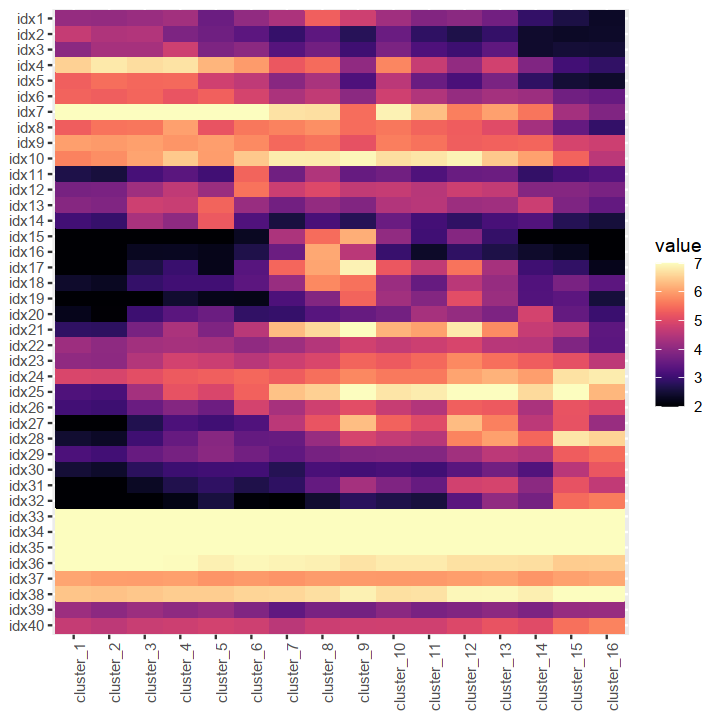

In [32]:
options(repr.plot.width = 6, repr.plot.height = 6)

# trial with peak set median accessibility
ggplot(data = melted_median_matrix, 
       aes(x = Var2, y = Var1, fill = value)) +
geom_tile()  + ylab(NULL) + xlab(NULL) +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(2, 7), oob=squish, option = "A") +
theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [33]:
dim(matrix_to_plot)

[1] 763167     16

In [34]:
SUBSAMPLE = 50

In [35]:
matrix_to_plot_ordered = matrix_to_plot[order(factor(assigned_peak_idx,
                                                    levels=peak_set_order)), ]

old_to_new_peak_set_idx_map = list()
for (i in seq(length(peak_set_order))) {
    old_to_new_peak_set_idx_map[[peak_set_order[i]]] = as.character(i)
}

# map to new order of peaks. This is used to facet, which automatically arranges in new peak order (1..num_peak_sets)
peak_assignments = unlist(old_to_new_peak_set_idx_map[as.character(sort(factor(assigned_peak_idx,levels=peak_set_order)))])

matrix_to_plot_ordered = matrix_to_plot_ordered[seq(1, nrow(matrix_to_plot_ordered), SUBSAMPLE), ]
peak_assignments = peak_assignments[seq(1, length(peak_assignments), SUBSAMPLE)]

dim(matrix_to_plot_ordered)
length(peak_assignments)

[1] 15264    16

[1] 15264

In [36]:
melted_matrix_to_plot = melt(as.matrix(matrix_to_plot_ordered))
melted_matrix_to_plot$Var1 = factor(melted_matrix_to_plot$Var1, levels = rownames(matrix_to_plot_ordered))
melted_matrix_to_plot$Var2 = factor(melted_matrix_to_plot$Var2, levels = colnames(matrix_to_plot_ordered))
head(melted_matrix_to_plot, 2)

Var1                     Var2      value   
1 chr1:180207952-180208152 cluster_1 5.376502
2 chr1:230857457-230857726 cluster_1 5.040713

In [37]:
cluster_config_colourbar_df = cluster_config
cluster_config_colourbar_df$text = paste(cluster_config_colourbar_df$new_cluster, 
                                         cluster_config_colourbar_df$description,
                                        sep =' - ')
cluster_config_colourbar_df = cluster_config_colourbar_df[order(cluster_config_colourbar_df$new_cluster), ]

# choose clusters properly
# Removing those not selected currently
cluster_config_colourbar_df = cluster_config_colourbar_df[1:16, ]
cluster_config_colourbar_df$text = factor(cluster_config_colourbar_df$text, 
                                         levels=cluster_config_colourbar_df$text)


cluster_colourbar <- ggplot(cluster_config_colourbar_df, aes(x=as.factor(text), 
                                                y=1, 
                                                fill = as.factor(text), 
                                                label=as.factor(text))) +
  geom_bar(stat="identity") +
#   xlab("Cluster") +
  theme_void() +
  scale_fill_manual(values = cluster_config_colourbar_df$colour) +
  theme(legend.position = 'none',
        axis.text.x = element_text(size=12, angle=90, hjust=1),
        axis.title.x = element_blank()) #element_text(size=16))

In [92]:
heatmap <- ggplot(data = melted_matrix_to_plot, 
       aes(x = Var2, y = Var1, fill = value)) +
geom_tile()  + ylab(NULL) + xlab(NULL) +  
geom_raster(aes(fill=value)) +
facet_grid(as.integer(peak_assignments) ~ ., switch = "y", scales = "free_y", space = "free_y")+
scale_fill_viridis(limits=c(2, 7), oob=squish, option = "A", name="Log2\nInsertions") +
theme_minimal() +
theme(axis.text.x = element_blank() , # element_text(angle = 90, hjust = 1),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.ticks.x=element_blank(),     
        strip.background = element_blank(),      
        strip.text.y.left = element_text(angle = 0, size=7),
        panel.spacing = unit(0.15, "lines"))

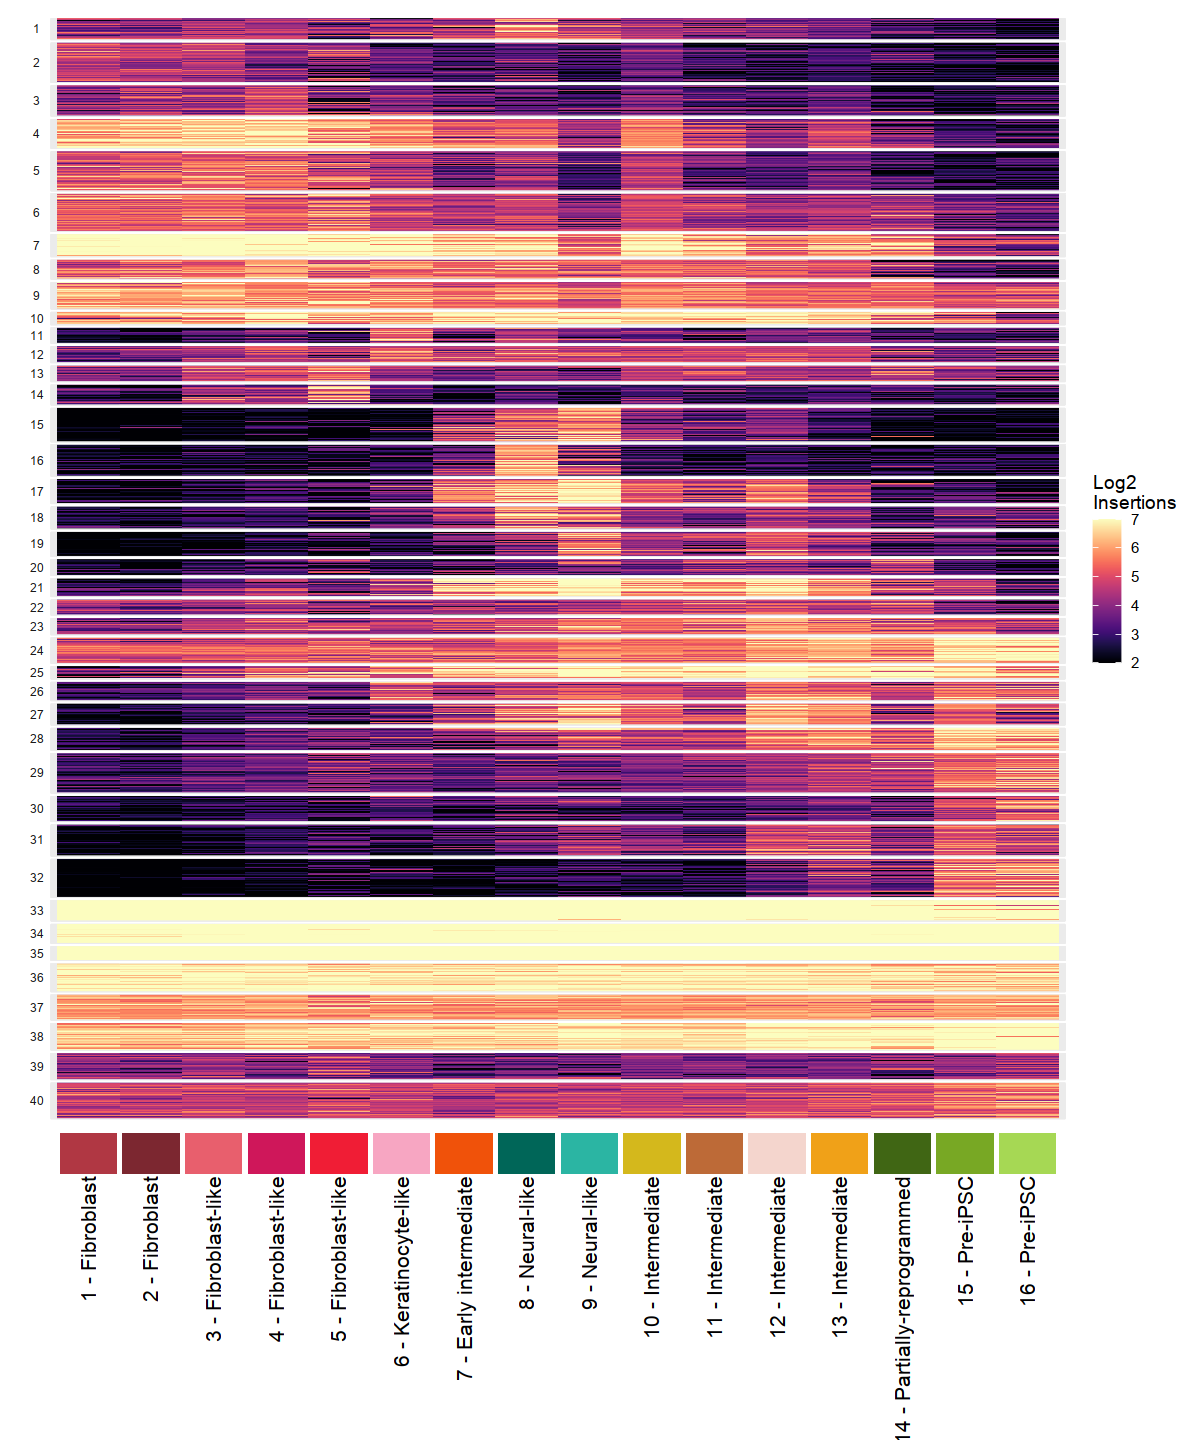

In [85]:
options(repr.plot.width = 10, repr.plot.height = 12)

cluster_by_day_with_colourbar = wrap_plots(heatmap, cluster_colourbar, nrow=2, heights=c(10,0.4))
cluster_by_day_with_colourbar

In [40]:
old_to_new_peak_set_idx_map

$idx1
[1] "1"

$idx2
[1] "2"

$idx3
[1] "3"

$idx4
[1] "4"

$idx5
[1] "5"

$idx6
[1] "6"

$idx7
[1] "7"

$idx8
[1] "8"

$idx9
[1] "9"

$idx10
[1] "10"

$idx11
[1] "11"

$idx12
[1] "12"

$idx13
[1] "13"

$idx14
[1] "14"

$idx15
[1] "15"

$idx16
[1] "16"

$idx17
[1] "17"

$idx18
[1] "18"

$idx19
[1] "19"

$idx20
[1] "20"

$idx21
[1] "21"

$idx22
[1] "22"

$idx23
[1] "23"

$idx24
[1] "24"

$idx25
[1] "25"

$idx26
[1] "26"

$idx27
[1] "27"

$idx28
[1] "28"

$idx29
[1] "29"

$idx30
[1] "30"

$idx31
[1] "31"

$idx32
[1] "32"

$idx33
[1] "33"

$idx34
[1] "34"

$idx35
[1] "35"

$idx36
[1] "36"

$idx37
[1] "37"

$idx38
[1] "38"

$idx39
[1] "39"

$idx40
[1] "40"

In [93]:
saveRDS(cluster_by_day_with_colourbar, file=sprintf("./subfigs/%s_peak_set_heatmap.rds",
                                format(Sys.Date(), "%Y%m%d")))
# required for building plot
saveRDS(peak_assignments, file=sprintf("./subfigs/%s_peak_set_heatmap_peak_assignments.rds",
                                format(Sys.Date(), "%Y%m%d")))

## Gridmaps

In [44]:
NROW=3
NCOL=4
ORDER = c("idx4", "idx6", "idx8", "idx9", 
          "idx11", "idx14", "idx15", "idx21",
          "idx25", "idx28", "idx32", "idx34")

stopifnot(length(ORDER)==NROW*NCOL)

In [53]:
peak_regions_str = as.character(peak_regions_gr)

In [74]:
plots = list()
for (i in seq(NROW*NCOL)) {
    matrix_peaks_in_peak_set = (peak_regions_str %in% rownames(binnorm_log_cts)[peak_to_row_idx==ORDER[i]])
    
    norm_reads_in_region = Matrix::rowSums(pmat[, matrix_peaks_in_peak_set])/pmatRowSums
    
    df = data.frame(umap1=metaData$umap1, 
                    umap2=metaData$umap2,
                    percent_reads=100*norm_reads_in_region)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 30000), ]

    plots[[i]] = ggplot(df) +
    # ggplot(df[df$percent_reads<2, ]) +
    geom_point(size=0.3, stroke = 0, alpha=1, aes(x=umap1 , y=umap2, col=percent_reads)) +
    ggtitle(sprintf("Peak Set %s (%d peaks)",  
                    old_to_new_peak_set_idx_map[[ORDER[i]]], # mapping to order in above heatmap
                    sum(matrix_peaks_in_peak_set))) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits= c(0, 
                                  quantile(100*norm_reads_in_region, 0.99)), 
                          oob=squish, option = "B",
                         name='Normalized\nInsertions') +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         axis.ticks = element_blank(),
         axis.text =element_blank(),
         panel.border = element_rect(colour = "black", fill=NA, size=0.5)) + 
    coord_fixed()
}

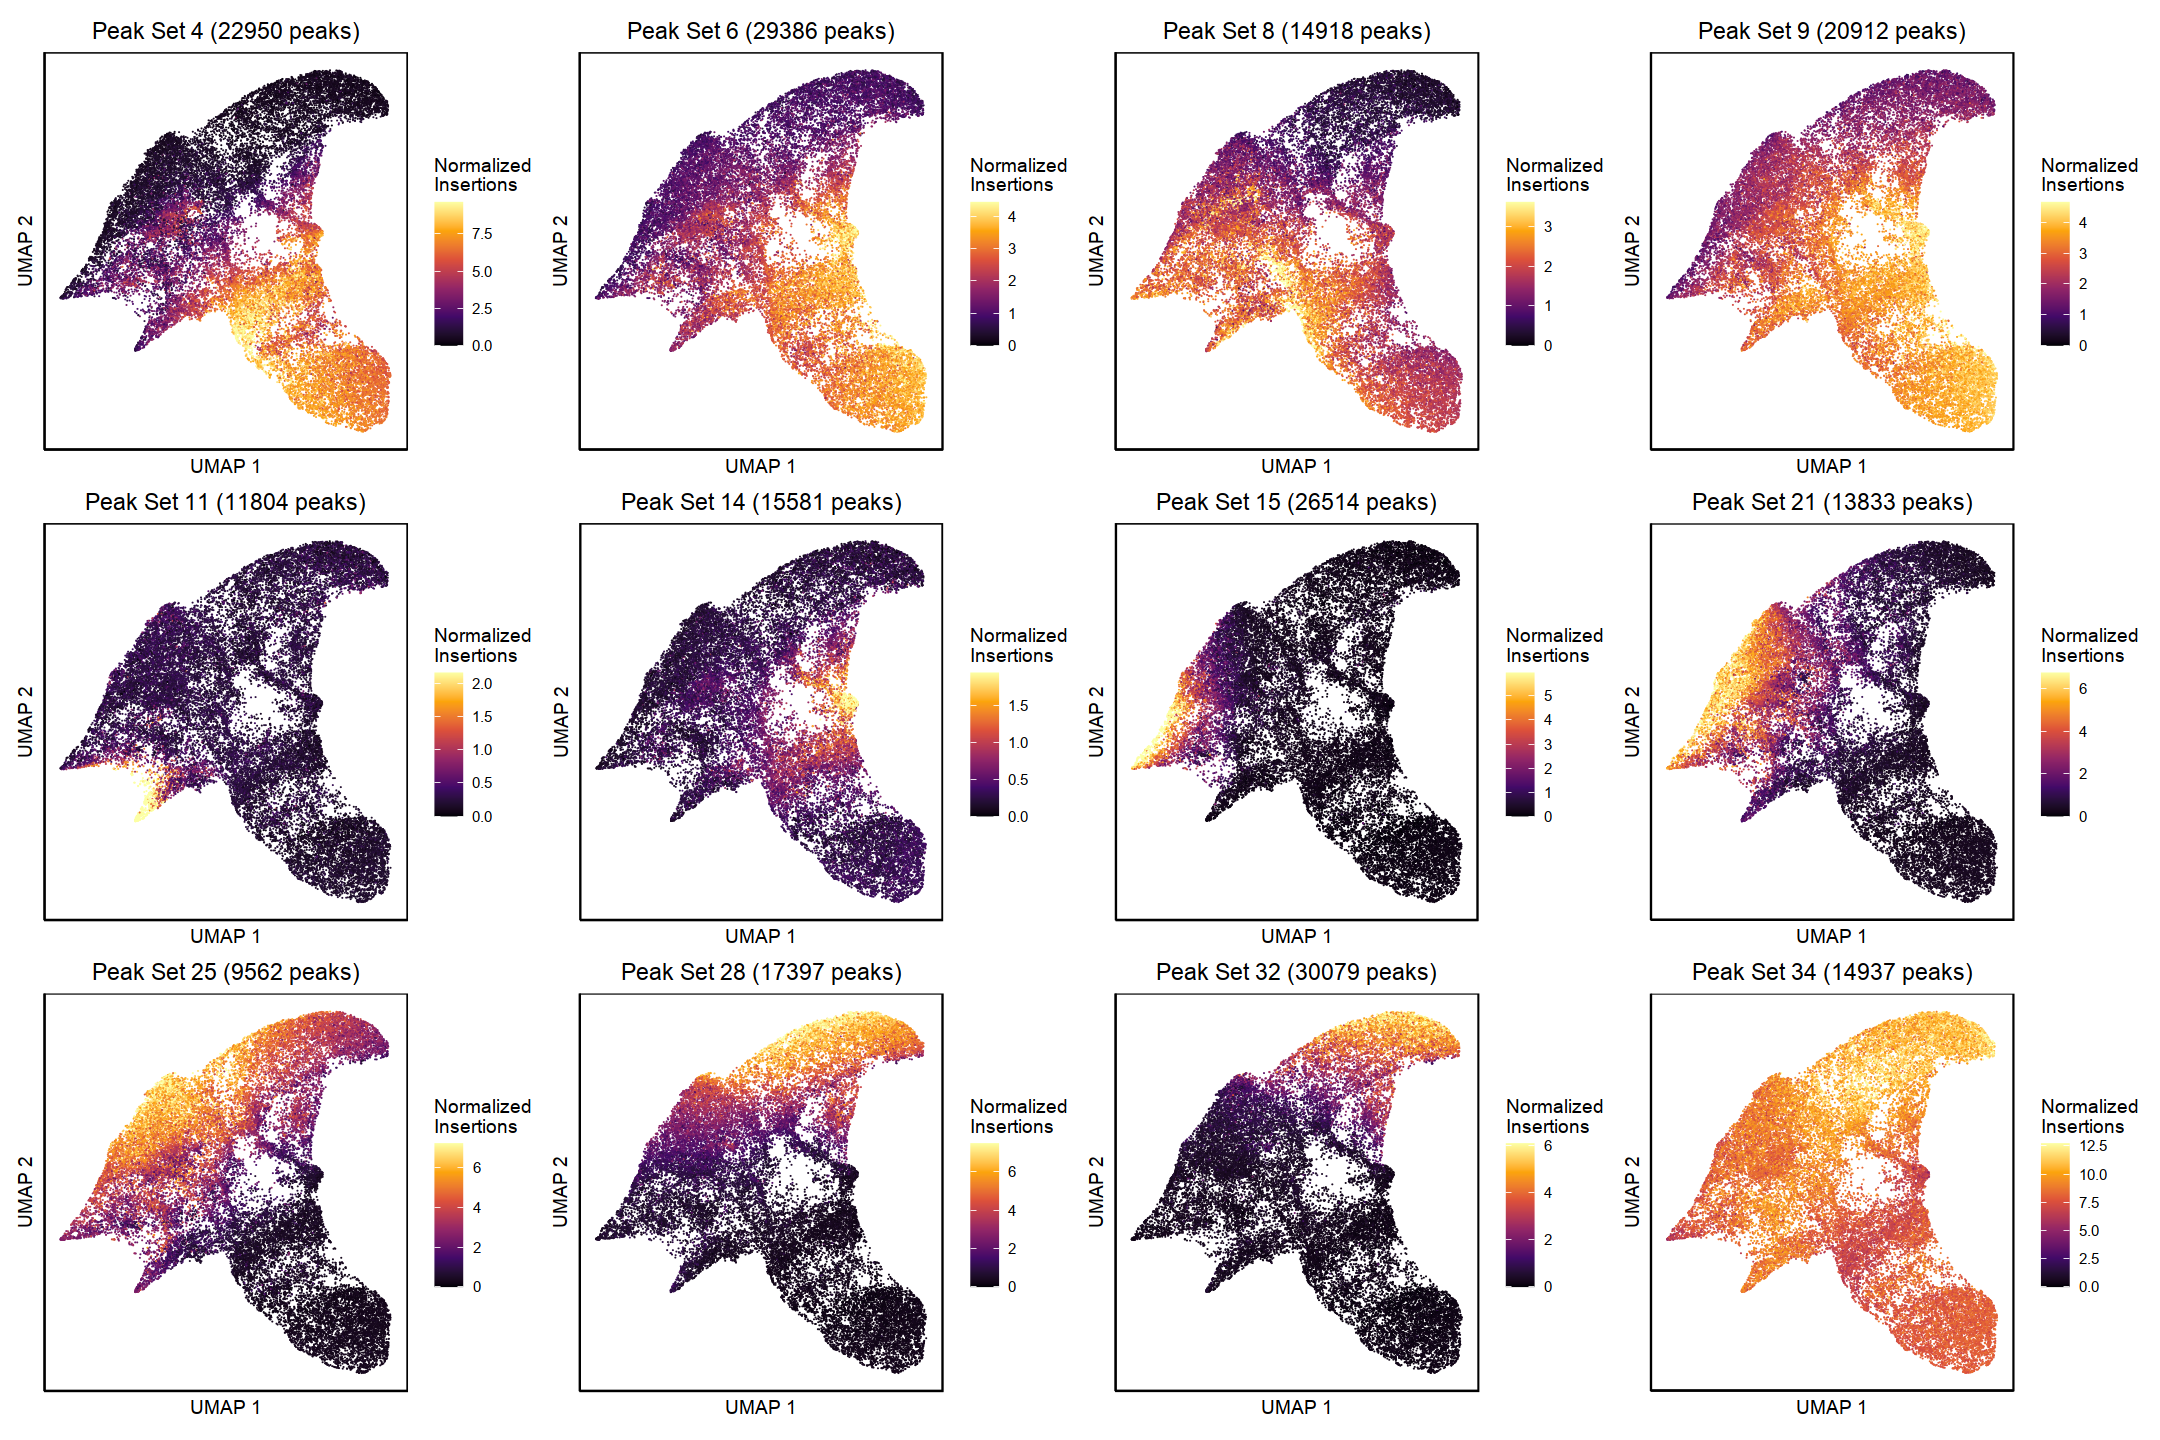

In [80]:
options(repr.plot.width = 4.5*NCOL, repr.plot.height = 12)
gridmap = wrap_plots(plots, ncol = NCOL) 

gridmap

In [81]:
saveRDS(gridmap, file=sprintf("./subfigs/%s_gridmap.rds",
                            format(Sys.Date(), "%Y%m%d")))

### Heatmap with Gridmap

In [77]:
vertical_spacers <- function(plot, heights=c(0,1,0)) {
    wrap_plots(plot_spacer(), plot, plot_spacer(), ncol=1, heights=heights)
}

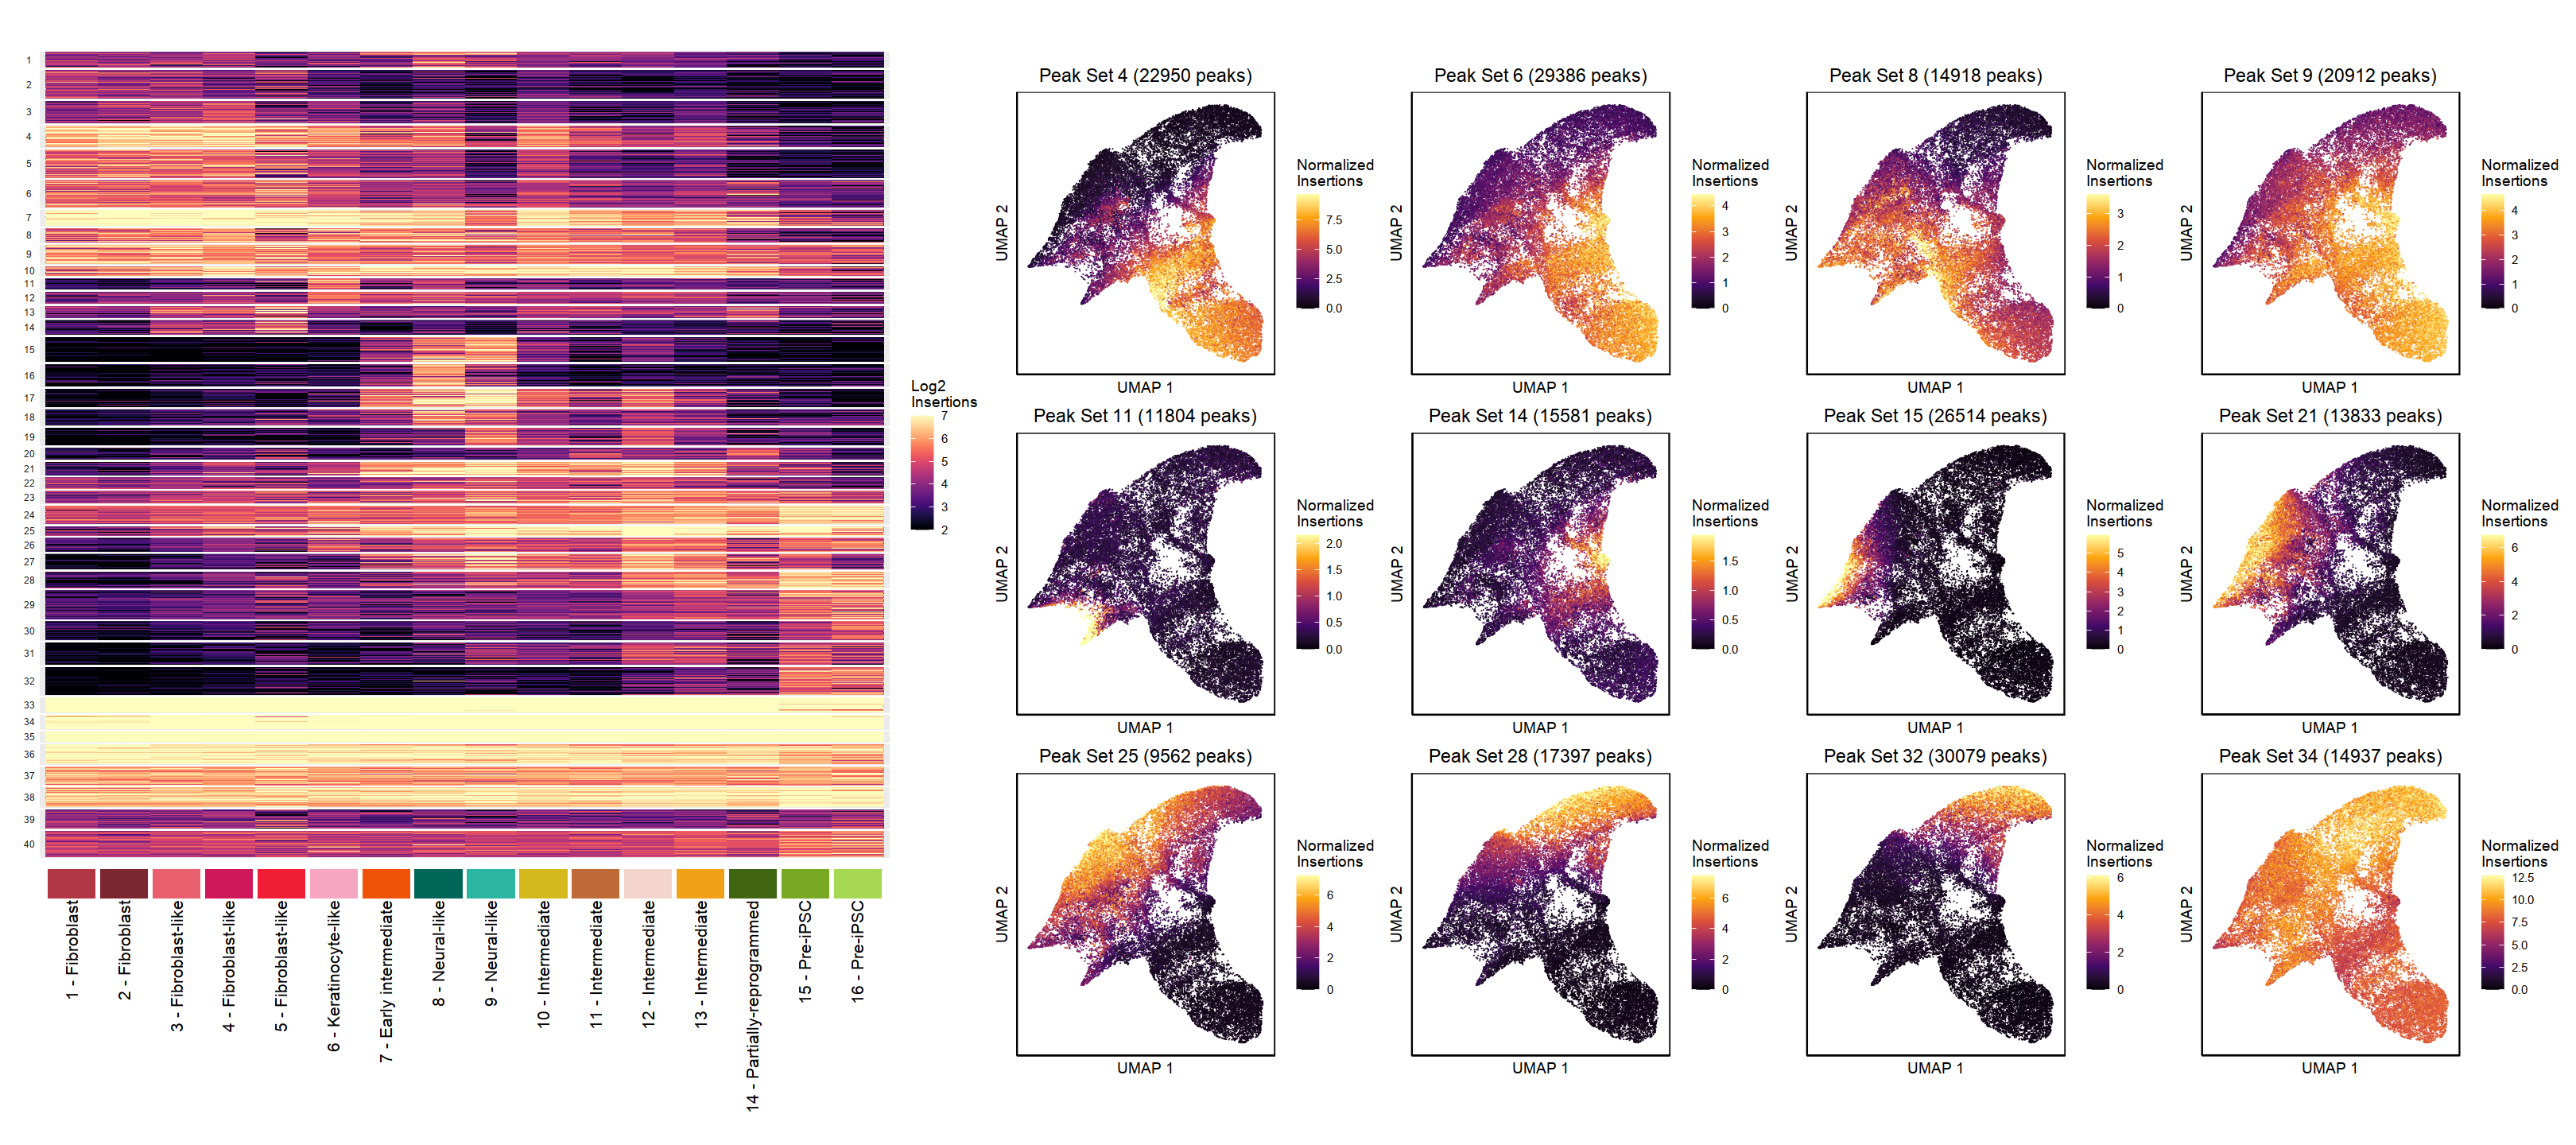

In [78]:
# together
options(repr.plot.width = 27, repr.plot.height = 12)

wrap_plots(vertical_spacers(cluster_by_day_with_colourbar),
           wrap_plots(plots, ncol = NCOL),
           widths=c(10,17))